In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Binarizer, LabelEncoder, MaxAbsScaler, MinMaxScaler, OneHotEncoder, \
    OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score


# Exercise 2 - Debugging - Drugs

The dataset contains a set of patients, all of whom suffered from the same illness.
During their course of treatment, each patient responded to one of 5 medications: Drug A, Drug B, Drug c, Drug x or y.

This complex dataset proposes a set of challenges that you'll try to overcome. A basic ML pipeline is already in place. You have to optimize the performance of the model by applying good practices, debugging pre-processing errors, etc.

**Rules**:
- Do not use other modules than those already imported *(or do it only if your own code is not working. In this case, keep your own code in the notebook, commented, so that we know what you tried)*.
- Explain **all** of your choices. For every task, choose the most appropriate option for this problem and describe your choice.
- You can modify any parts of the code or replace the model by one already used in previous PWs.

**Work to do**:
- [ ] Apply a type of normalization.
- [ ] Encode categorical data.
- [ ] Use all columns in the dataset (or choose the most meaningful features).
- [ ] Choose a more appropriate metric.
- [ ] Optimize hyper-parameters.
- [ ] Test the model performance correctly using a separated test set.
- Apply **two** of those techniques:
  - [ ] Keep relative class frequencies in the train/test sets (check train_test_split docs)
  - [ ] Show which feature(s) are the most correlated to the target.
  - [ ] Use cross-validation.

In [2]:
df = pd.read_csv("drug.csv")
df.head()

,age,sex,bp,cholesterol,Na_to_K,drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


## 0) Quick Display of data 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          200 non-null    int64  
 1   sex          200 non-null    object 
 2   bp           200 non-null    object 
 3   cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


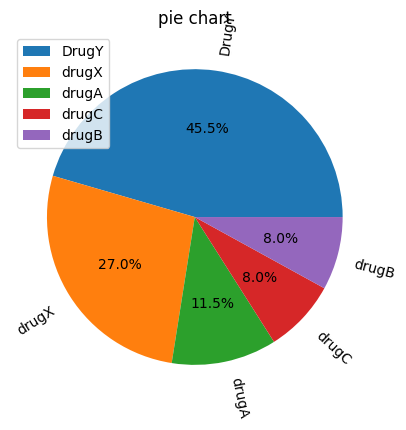

In [4]:
from matplotlib import pyplot as plt

counts = df['drug'].value_counts()

categories = ['DrugY', 'drugX', 'drugA', 'drugC', 'drugB']
plt.pie(counts,
        labels=categories,
        autopct='%1.1f%%',
        rotatelabels=True)
plt.title('pie chart')
plt.legend()
plt.show()

some drugs are more present than others in the ds

In [5]:
print("Unique values in 'cholesterol' col :", df['cholesterol'].unique())
print("Unique values in 'bp' col are:", df['bp'].unique())

Unique values in 'cholesterol' col : ['HIGH' 'NORMAL']
Unique values in 'bp' col are: ['HIGH' 'LOW' 'NORMAL']


Text(0, 0.5, 'Count')

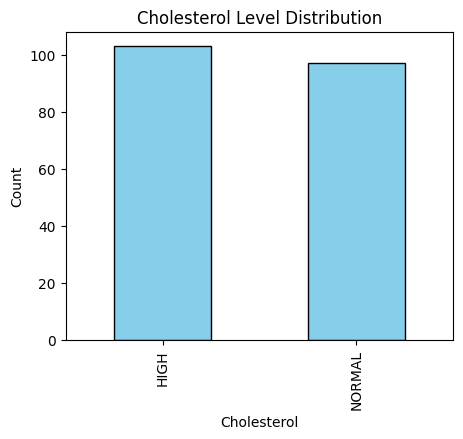

In [6]:
# Plot cholesterol distribution
plt.figure(figsize=(5,4))
df['cholesterol'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Cholesterol Level Distribution")
plt.xlabel("Cholesterol")
plt.ylabel("Count")

comment : well distributed

Text(0, 0.5, 'Count')

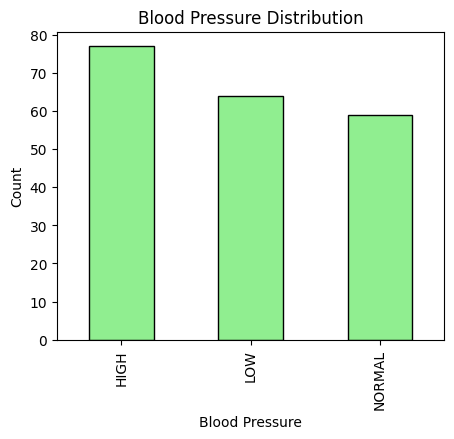

In [7]:
# Plot blood pressure distribution
plt.figure(figsize=(5,4))
df['bp'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Blood Pressure Distribution")
plt.xlabel("Blood Pressure")
plt.ylabel("Count")

comment : well distributed although slightly more samples on 'HIGH'


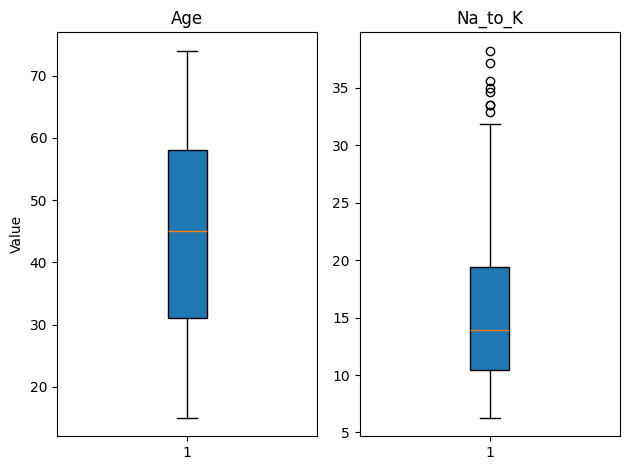

In [8]:
# Age distribution to verify if there are outliers
plt.subplot(1, 2, 1)
plt.boxplot(df['age'], patch_artist=True)
plt.title('Age')
plt.ylabel('Value')

# Na_to_K distribution to verify if there are outliers
plt.subplot(1, 2, 2)
plt.boxplot(df['Na_to_K'], patch_artist=True)
plt.title('Na_to_K')

plt.tight_layout()
plt.show()

comment : for age there are no outliers (expected). For Na_to_k some values are higher than usual but not do not seem like measurement errors so they might actual represent real outliers => we choose to keep them.

## 1) Feature Engineering
We start the pipeline by transforming the format of the following features :

- sex : to binary encoding as only 2 options available
- bp : this is considered here as ordinal as HIGH > NORMAL > LOW. So ordinal encoder is manually applied
- cholesterol : only 2 options are available so we also used binary encoding.

A basic feature engineering is done for all 3 to ensure same format when applying manual processing.

In [9]:
# 'sex' feature only has two options => binary encoding
# clean the variable and ensure format first
df['sex'] = df['sex'].astype(str).str.strip().str.upper()
df['is_male'] = df['sex'].map({'F': 0, 'M': 1}).astype('int8')

# 'cholesterol' feature only has two options => binary encoding
# clean the variable and ensure format first
df['cholesterol'] = df['cholesterol'].astype(str).str.strip().str.upper()
df['is_chol_high'] = (df['cholesterol'] == 'HIGH').astype('int8')

# encode 'bp' as ordinal (LOW < NORMAL < HIGH)
# clean the variable and ensure format first
df['bp'] = df['bp'].astype(str).str.strip().str.upper()
bp_mapping = {'LOW': 0, 'NORMAL': 1, 'HIGH': 2}
df['bp'] = df['bp'].map(bp_mapping).astype('int8')

# drug as label encoder => classification output so ok, no need to OHE
le_drug = LabelEncoder()
df['drug'] = le_drug.fit_transform(df['drug']).astype('int16')

# Drop old categorical columns
df = df.drop(columns=['sex', 'cholesterol'])

df.head(2)

,age,bp,Na_to_K,drug,is_male,is_chol_high
0,23,2,25.355,4,0,1
1,47,0,13.093,2,1,1


### 1.2) Application of normalization

Very important step, considering the future model we are using is KNN, a distance based model.

- Age : MinMaxScaler used because the range is known in advance and no outliers as seen during the quick eda done.
- Na_to_K : scaled with StandardScaler because it contains outliers and a skewed distribution.



In [10]:
scaler_age = MinMaxScaler()
scaler_nak = StandardScaler()

df['age'] = scaler_age.fit_transform(df[['age']])
df['Na_to_K'] = scaler_nak.fit_transform(df[['Na_to_K']])

df.head(3)

,age,bp,Na_to_K,drug,is_male,is_chol_high
0,0.135593,2,1.286522,4,0,1
1,0.542373,0,-0.415145,2,1,1
2,0.542373,0,-0.828558,2,1,1


In [11]:
X = df.drop(columns=["drug"])
y = df["drug"]

In [12]:
# stratify here ensures that the class proportions in the train and test sets are the same as in the original dataset 
# which are not proportionally ...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.head(2)

,age,bp,Na_to_K,is_male,is_chol_high
196,0.016949,0,-0.565995,1,1
134,0.457627,2,0.687150,0,1


## 2) Model Tuning
Training strategy for KNN:
- split : cross validation of 5 splits
- objectif : tuning parameter k of knn

Problems to be expected: as seen, some 'y' classes are less represented in the ds, even if stratified split.

In [13]:
k_values = [4, 5, 6, 7, 8, 9]
models = []
n_splits = 5

In [14]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
results = {}  # store metrics for each k

# for each k of knn model store different metrics to better understand which k to choose
for k in k_values:
    print(f" => Evaluating KNN with k={k}")

    f1_scores = []
    prec_scores = []
    rec_scores = []
    acc_scores = []

    knn = KNeighborsClassifier(n_neighbors=k)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
        # get the random chosen splits
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # train and test model on the val set
        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)

        # Compute metrics (macro average means that all classes equally weight the scores)
        f1 = f1_score(y_val, y_pred, average='macro')
        prec = precision_score(y_val, y_pred, average='macro')
        rec = recall_score(y_val, y_pred, average='macro')
        acc = balanced_accuracy_score(y_val, y_pred)

        f1_scores.append(f1)
        prec_scores.append(prec)
        rec_scores.append(rec)
        acc_scores.append(acc)

        print(f" => the fold {fold} : F1={f1:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, Accuracy={acc:.4f}")

    # Store results for this k
    results[k] = {
        'f1': f1_scores,
        'precision': prec_scores,
        'recall': rec_scores,
        'acc': acc_scores
    }

    print(f" Mean of the k={k}: "
          f"F1={np.mean(f1_scores):.4f}, "
          f"Precision={np.mean(prec_scores):.4f}, "
          f"Recall={np.mean(rec_scores):.4f}",
          f"Acc={np.mean(acc_scores):.4f}")

# print averages 
print("")
print("   Summary of Cross-Validation Results ")
for k, metrics_dict in results.items():
    f1_mean = np.mean(metrics_dict['f1'])
    prec_mean = np.mean(metrics_dict['precision'])
    rec_mean = np.mean(metrics_dict['recall'])
    acc = np.mean(metrics_dict['acc'])
    print(f"k={k}: mean F1={f1_mean:.4f}, Precision={prec_mean:.4f}, Recall={rec_mean:.4f}, Acc={acc:.4f}")


 => Evaluating KNN with k=4
 => the fold 1 : F1=0.8078, Precision=0.8875, Recall=0.8000, Accuracy=0.8000
 => the fold 2 : F1=0.8044, Precision=0.8788, Recall=0.8238, Accuracy=0.8238
 => the fold 3 : F1=0.7600, Precision=0.7333, Recall=0.8000, Accuracy=0.8000
 => the fold 4 : F1=0.6934, Precision=0.6770, Recall=0.8067, Accuracy=0.8067
 => the fold 5 : F1=0.6816, Precision=0.6803, Recall=0.6933, Accuracy=0.6933
 Mean of the k=4: F1=0.7495, Precision=0.7714, Recall=0.7848 Acc=0.7848
 => Evaluating KNN with k=5
 => the fold 1 : F1=0.7867, Precision=0.8667, Recall=0.7867, Accuracy=0.7867
 => the fold 2 : F1=0.6899, Precision=0.6597, Recall=0.7571, Accuracy=0.7571
 => the fold 3 : F1=0.7333, Precision=0.7200, Recall=0.7500, Accuracy=0.7500
 => the fold 4 : F1=0.7613, Precision=0.7400, Recall=0.8467, Accuracy=0.8467
 => the fold 5 : F1=0.7878, Precision=0.7836, Recall=0.8267, Accuracy=0.8267
 Mean of the k=5: F1=0.7518, Precision=0.7540, Recall=0.7934 Acc=0.7934
 => Evaluating KNN with k=6
 =

/Users/pellandini/Documents/Master/Semestre 3/MachLe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/pellandini/Documents/Master/Semestre 3/MachLe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/pellandini/Documents/Master/Semestre 3/MachLe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

Comments : 

- The warning means that some classes were never predicted. This is likely because KNN is sensitive to class imbalance => when there are too few samples for a class, it struggles to recognize and predict them as there are few neighbours
- K=7 appears to work best
- Evaluation on validation set might be dangerous because there are not many samples in the dataset (and we are using -20% that were cut for test set)

## 3) Evaluation using Test Set

=>  Evaluation Metrics on the test set
  Balanced Accuracy : 0.8018181818181818
  Macro Precision   : 0.7675
  Macro Recall      : 0.8018181818181818
  Macro F1-score    : 0.7760376878023936
  Accuracy (global) : 0.825


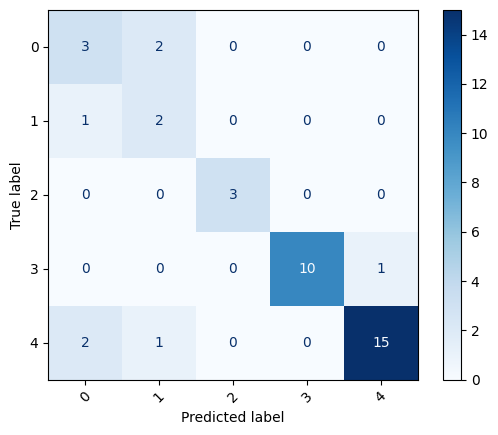

In [15]:
from sklearn.metrics import accuracy_score

# Final model with best K
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Predictions
y_pred = knn.predict(X_test)

# Metrics (macro = equal weight to each class)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
acc_balanced = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

# Print metrics cleanly
print("=>  Evaluation Metrics on the test set")
print(f"  Balanced Accuracy : {acc_balanced}")
print(f"  Macro Precision   : {prec}")
print(f"  Macro Recall      : {rec}")
print(f"  Macro F1-score    : {f1}")
print(f"  Accuracy (global) : {acc}")


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)

## Observations

In this exercise, our group explored various feature engineering techniques. The model achieved an accuracy of around 80%, which is a reasonable result given that we used KNN, a model particularly sensitive to class imbalance (as the target variable y is not evenly distributed).
To further improve performance, we could generate additional data for the minority classes, or, if more real data were available, ensure a more balanced dataset during training by simply picking only the minimum count for all 'y'.